In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc

In [2]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 5
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def tune_stimuli(data):
    data = (data - data.min()) / (data.max() - data.min())
    q95 = np.percentile(data, 95)
    data = np.where((data > q95), q95, data)
    data = np.exp(data*15)
    data = (data - data.min()) / (data.max() - data.min())
    data *= 15
    return data

In [5]:
def get_stimuli(file_name):
    img = Image.open(file_name)
    img.load()
    img_arr = np.asarray(img, dtype="int32")
    stimuli = np.absolute(img_arr)/255
    img.close()
    
    stimuli_on = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1,1.05)), mode='same')
    stimuli_on = tune_stimuli(stimuli_on)
    stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1.05,1)), mode='same')
    stimuli_off = tune_stimuli(stimuli_off)

    c, axarr = subplots(1, 3, figsize = (10, 3))
    axarr[0].imshow(stimuli, cmap = cmap.get_cmap('binary'))
    axarr[0].title.set_text('stimuli')
    axarr[1].imshow(stimuli_on, cmap = cmap.get_cmap('binary'))
    axarr[1].title.set_text('stimuli_on')
    axarr[2].imshow(stimuli_off, cmap = cmap.get_cmap('binary'))
    axarr[2].title.set_text('stimuli_off')
    
    return stimuli_on, stimuli_off

In [6]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [7]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

In [8]:
def plot_lateral_distribution(name):
    if (name == 'L3_L3'):
        shape = (n_L3, n_L3)
        radius = 1; inner = False
    elif (name == 'L3_L2'):
        shape = (n_L3, n_L2)
        radius = 0; inner = True
        
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    list_dic = {}; sum_dic = {}; total_sum = 0
    
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}
    for s_index in range(orientations):
        for t_index in range(orientations):
            list_dic[c[s_index]+c[t_index]] = []
            sum_dic[c[s_index]+c[t_index]] = 0

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), radius, inner, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        list_dic[c[s_index]+c[t_index]].append(weights[source][target])
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        total_sum += abs(weights[source][target])
                        
    plt.figure(figsize=(17,4))
    for s_index in range(orientations):
        for t_index in range(orientations):
            plt.plot(list_dic[c[s_index]+c[t_index]], label=c[s_index]+c[t_index])
            print(c[s_index]+c[t_index], sum_dic[c[s_index]+c[t_index]], 
                  'of', total_sum, ':', sum_dic[c[s_index]+c[t_index]]*100/total_sum)
    
    plt.legend(); plt.show()

# INITIALIZE

In [9]:
stimuli_file_path = './pic_60_hv.tif'

initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 2                     # 2/3/4/5/6
w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

c_length = 15
r_length = (c_length*l_s)   # (c_length*2*w_s)
orientations = 4

h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_LGN = r_length*r_length
n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 15

single_example_time = 0.35 * second
resting_time = 0.15 * second

# delay = {}
# delay = (0*ms, 5*ms)              # min and max delay
# minDelay = delay[0]
# maxDelay = delay[1]
# deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.1 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [10]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [11]:
neuron_groups = {}
neuron_groups_list = [
    ('L4_i_NF', 'i'), ('L4_NF', 'e'), ('L4_i_FN', 'i'), ('L4_FN', 'e'),
    ('L4', 'e'), ('L3', 'e'), ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v    = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v    = v_rest_i - 40.*mV 

input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

gc.collect()

1596

In [12]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

input_neuron_conn = [
    ['LGN_on_L4_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_NF', 'e'],
    ['LGN_off_L4_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_NF', 'e'],
    ['LGN_off_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_i_NF', 'e'],
    ['LGN_on_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_i_NF', 'e'],
    
    ['LGN_off_L4_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_FN', 'e'],
    ['LGN_on_L4_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_FN', 'e'],
    ['LGN_on_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_i_FN', 'e'],
    ['LGN_off_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_i_FN', 'e'],
]

neuron_neuron_conn = [
    ['L4_i_L4_NF', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_NF', 'L4_NF', 'i', False],
    ['L4_i_L4_FN', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_FN', 'L4_FN', 'i', False],
    ['L4_NF_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_NF', 'L4', 'e', False],
    ['L4_FN_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_FN', 'L4', 'e', False],
    
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]


for name, shape, weight_file, source, target, _ in input_neuron_conn:
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(input_groups[source], neuron_groups[target], model=model, on_pre=pre_e, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
#     connections[name].delay = 'minDelay + rand() * deltaDelay'
    
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1816

In [13]:
spike_monitors = {}

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])

for name,_ in neuron_groups_list:
    spike_monitors[name]   = SpikeMonitor(neuron_groups[name])

In [14]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors]:
    for key in obj_list:
        net.add(obj_list[key])

hh 495.29421711673365 of 7924.58754913424 : 6.250094582788027
hv 495.17356138076894 of 7924.58754913424 : 6.2485720336936215
hd1 495.26144577402414 of 7924.58754913424 : 6.249681042745642
hd2 495.27679136775896 of 7924.58754913424 : 6.2498746880759475
vh 495.2149906401829 of 7924.58754913424 : 6.249094827582352
vv 495.26642466673843 of 7924.58754913424 : 6.249743871160161
vd1 495.2245976281596 of 7924.58754913424 : 6.249216057714736
vd2 495.3398273880564 of 7924.58754913424 : 6.250670136670673
d1h 495.3789233461039 of 7924.58754913424 : 6.251163486738485
d1v 495.265903008009 of 7924.58754913424 : 6.249737288373029
d1d1 495.2314490090065 of 7924.58754913424 : 6.249302514969506
d1d2 495.4016622399578 of 7924.58754913424 : 6.251450427777535
d2h 495.279717767265 of 7924.58754913424 : 6.249911616174576
d2v 495.2720986059045 of 7924.58754913424 : 6.249815470333378
d2d1 495.42089250299 of 7924.58754913424 : 6.25169309356819
d2d2 495.2850466925792 of 7924.58754913424 : 6.249978861634117


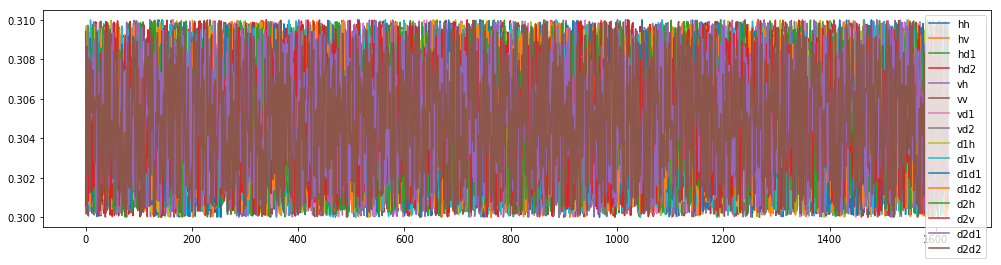

In [15]:
plot_lateral_distribution('L3_L3')

In [16]:
# plot_lateral_distribution('L3_L2')

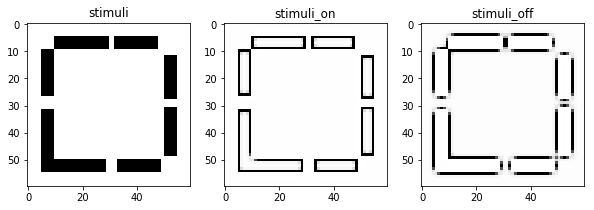

In [17]:
# load stimuli files
stimuli_on, stimuli_off = get_stimuli(stimuli_file_path)

# TRAIN

In [18]:
previous_spike_count = np.zeros(n_L4)
net.run(resting_time)

j = 0
while j < (num_epochs):
    spike_rates_on = stimuli_on.reshape((n_LGN)) / 8. * input_intensity
    spike_rates_off = stimuli_off.reshape((n_LGN)) / 8. * input_intensity

    input_groups['LGN_on'].rates = spike_rates_on * Hz
    input_groups['LGN_off'].rates = spike_rates_off * Hz

    print('run example number:', j+1, 'of', num_epochs)
    net.run(single_example_time, report='text')   # 0.35 s

    current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_monitors['L4'].count[:])

    if np.sum(current_spike_count) < 1:
        if (input_intensity == 5):
            break;
        print("F - spike count", np.sum(current_spike_count))
        input_intensity += 1 
    else:     
        print("S - spike count", np.sum(current_spike_count))
        input_intensity = start_input_intensity
        j += 1
        
    input_groups['LGN_on'].rates = 0 * Hz
    input_groups['LGN_off'].rates = 0 * Hz
    net.run(resting_time)

    gc.collect()

run example number: 1 of 15
Starting simulation at t=150. ms for a duration of 0.35 s
0.35 (100%) simulated in 9s
S - spike count 48.0
run example number: 2 of 15
Starting simulation at t=0.65 s for a duration of 0.35 s
0.35 (100%) simulated in 9s
S - spike count 70
run example number: 3 of 15
Starting simulation at t=1.15 s for a duration of 0.35 s
0.35 (100%) simulated in 9s
S - spike count 57
run example number: 4 of 15
Starting simulation at t=1.65 s for a duration of 0.35 s
0.35 (100%) simulated in 6s
S - spike count 72
run example number: 5 of 15
Starting simulation at t=2.15 s for a duration of 0.35 s
0.35 (100%) simulated in 7s
S - spike count 53
run example number: 6 of 15
Starting simulation at t=2.65 s for a duration of 0.35 s
0.35 (100%) simulated in 7s
S - spike count 75
run example number: 7 of 15
Starting simulation at t=3.15 s for a duration of 0.35 s
0.35 (100%) simulated in 8s
S - spike count 63
run example number: 8 of 15
Starting simulation at t=3.65 s for a duratio

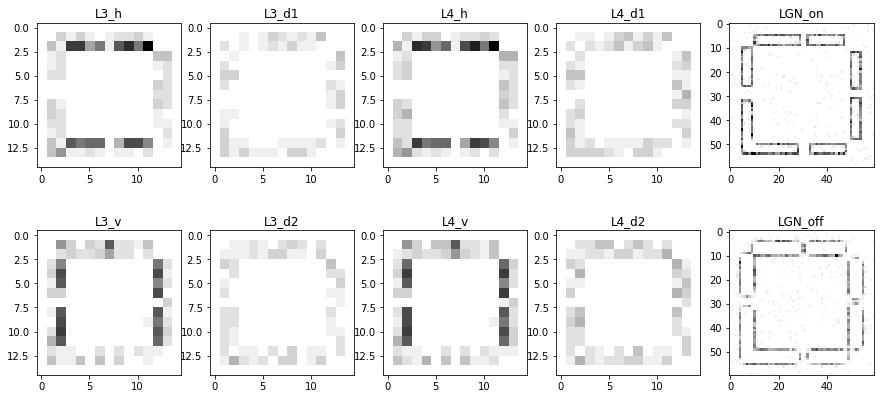

In [19]:
c_shape = (c_length, c_length, orientations)
r_shape = (r_length, r_length)
fig, axarr = subplots(2,5, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h')
axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v')
axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1')
axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2')


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')


data = np.copy(spike_monitors['LGN_on'].count).reshape(r_shape)
v_min = data.min(); v_max = data.max()
axarr[0,4].imshow(data, vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,4].title.set_text('LGN_on')

data = np.copy(spike_monitors['LGN_off'].count).reshape(r_shape)
v_min = data.min(); v_max = data.max()
axarr[1,4].imshow(data, vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,4].title.set_text('LGN_off')

In [20]:
gc.collect()

15

hh 497.2951948852578 of 7940.037153391082 : 6.263134356655621
hv 496.8967864863041 of 7940.037153391082 : 6.258116642112767
hd1 495.8736248190509 of 7940.037153391082 : 6.24523053531645
hd2 496.2126216542424 of 7940.037153391082 : 6.249499996890024
vh 496.90343232454353 of 7940.037153391082 : 6.258200342454605
vv 497.9148306230469 of 7940.037153391082 : 6.270938296685353
vd1 495.9529189374541 of 7940.037153391082 : 6.246229197122073
vd2 496.25779660006793 of 7940.037153391082 : 6.250068948205399
d1h 495.9250546060704 of 7940.037153391082 : 6.245878262600668
d1v 496.0931629386548 of 7940.037153391082 : 6.247995486101474
d1d1 495.5226963093396 of 7940.037153391082 : 6.240810801467202
d1d2 495.6977436330312 of 7940.037153391082 : 6.243015417394179
d2h 496.3025024896692 of 7940.037153391082 : 6.250631992039296
d2v 495.9662401135222 of 7940.037153391082 : 6.246396969335361
d2d1 495.70912326388554 of 7940.037153391082 : 6.243158737011387
d2d2 495.5134237069465 of 7940.037153391082 : 6.240694

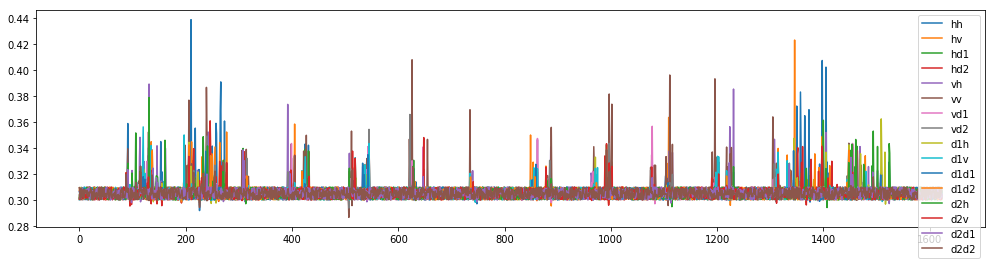

In [21]:
plot_lateral_distribution('L3_L3')

hh 497.2951948852578 of 7940.037153391082 : 6.263134356655621
hv 496.8967864863041 of 7940.037153391082 : 6.258116642112767
hd1 495.8736248190509 of 7940.037153391082 : 6.24523053531645
hd2 496.2126216542424 of 7940.037153391082 : 6.249499996890024
vh 496.90343232454353 of 7940.037153391082 : 6.258200342454605
vv 497.9148306230469 of 7940.037153391082 : 6.270938296685353
vd1 495.9529189374541 of 7940.037153391082 : 6.246229197122073
vd2 496.25779660006793 of 7940.037153391082 : 6.250068948205399
d1h 495.9250546060704 of 7940.037153391082 : 6.245878262600668
d1v 496.0931629386548 of 7940.037153391082 : 6.247995486101474
d1d1 495.5226963093396 of 7940.037153391082 : 6.240810801467202
d1d2 495.6977436330312 of 7940.037153391082 : 6.243015417394179
d2h 496.3025024896692 of 7940.037153391082 : 6.250631992039296
d2v 495.9662401135222 of 7940.037153391082 : 6.246396969335361
d2d1 495.70912326388554 of 7940.037153391082 : 6.243158737011387
d2d2 495.5134237069465 of 7940.037153391082 : 6.240694

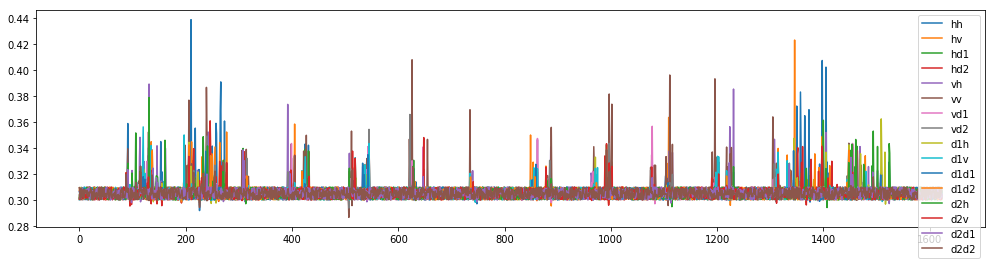

In [22]:
plot_lateral_distribution('L3_L3')

In [23]:
# save connections
# save_connections()

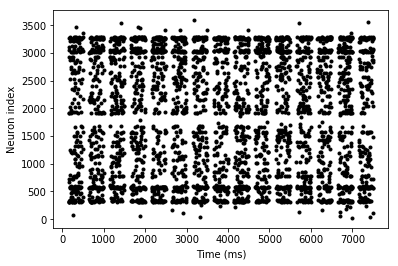

In [24]:
plot(spike_monitors['LGN_on'].t/ms, spike_monitors['LGN_on'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

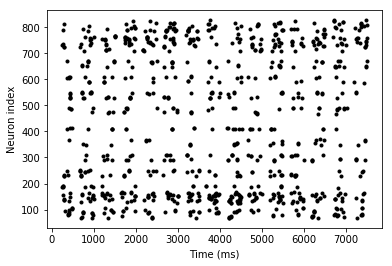

In [25]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

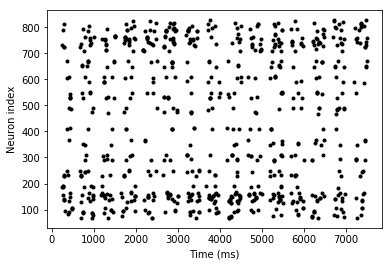

In [26]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

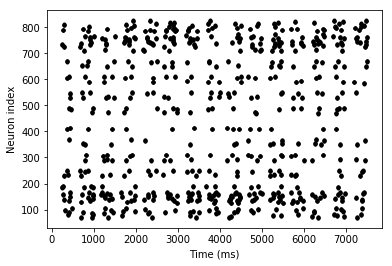

In [27]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [28]:
# spike_monitors['L3'].i

In [29]:
# junction point V 0 0
# junction point H 0 0
# junction left H 9 11
# junction down V 11 12
print("junction point V", spike_monitors['L3'].count[(2*c_length + 12)*orientations + v_index])
print("junction point H", spike_monitors['L3'].count[(2*c_length + 12)*orientations + h_index])
print("junction left H", spike_monitors['L3'].count[(2*c_length + 11)*orientations + h_index])
print("junction down V", spike_monitors['L3'].count[(3*c_length + 12)*orientations + v_index])

junction point V 0
junction point H 0
junction left H 17
junction down V 9


In [30]:
# Line point V 0 0
# Line point H 0 0
# Line Up V 12 10
# Line Down V 10 10
print("Line point V", spike_monitors['L3'].count[(7*c_length + 12)*orientations + v_index])
print("Line point H", spike_monitors['L3'].count[(7*c_length + 12)*orientations + h_index])
print("Line Up V", spike_monitors['L3'].count[(6*c_length + 12)*orientations + v_index])
print("Line Down V", spike_monitors['L3'].count[(8*c_length + 12)*orientations + v_index])

Line point V 0
Line point H 2
Line Up V 12
Line Down V 11
